## Weakly Supervised Localization : Class Activation map for mnist
간단한 CNN (Global Average Pooling)을 mnist 데이터에 대해서 학습하고 임의의 mnist 데이터 중 하나를 예측하고 Class Activation Map을 그리는 예제,  
**최성준 박사과정**의 아래의 코드를 참고하였음.  

구조 : Conv-Conv-Max_pool-Conv-Conv-Global_average_pool-fully_connected  
(activation function으로 relu를 활용하며, relu를 통과하기전 batch normalization 활용)

참고 코드 : https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/gap_mnist.ipynb  
논문 : http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

### Load modules

In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix
from scipy.misc import imresize
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [2]:
tf.set_random_seed(777)
mnist = input_data.read_data_sets(train_dir = './MNIST_data/', one_hot = True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


### Define CNN

In [3]:
class CNN_with_gap:
    def __init__(self, sess):
        self.sess = sess
        self.build_net()
    # Generate a graph
    def build_net(self):
        with tf.variable_scope('weights'):
            self.weights = {
                'w1' : tf.get_variable(name = 'weight1', shape = [3,3,1,32],
                                       initializer = tf.contrib.layers.variance_scaling_initializer()), 
                'w2' : tf.get_variable(name = 'weight2', shape = [3,3,32,64],
                                       initializer = tf.contrib.layers.variance_scaling_initializer()),
                'w3' : tf.get_variable(name = 'weight3', shape = [3,3,64,96],
                                       initializer = tf.contrib.layers.variance_scaling_initializer()),
                'w4' : tf.get_variable(name = 'weight4', shape = [3,3,96,128],
                                       initializer = tf.contrib.layers.variance_scaling_initializer()),
                'w5' : tf.get_variable(name = 'weight5', shape = [128, 10],
                                       initializer = tf.contrib.layers.xavier_initializer())
            }
            
        with tf.variable_scope('bias'):
            self.bias = {
            'b1' : tf.get_variable(name = 'bias1', shape = [32], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
            'b2' : tf.get_variable(name = 'bias2', shape = [64], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
            'b3' : tf.get_variable(name = 'bias3', shape = [96], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
            'b4' : tf.get_variable(name = 'bias4', shape = [128], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
            'b5' : tf.get_variable(name = 'bias5', shape = [10], initializer = tf.random_normal_initializer())
            }
        
        self.X = tf.placeholder(dtype = tf.float32, shape = [None, 784])
        self.Ximg = tf.reshape(tensor = self.X, shape = [-1, 28, 28, 1]) #reshape vector to image
        self.Y = tf.placeholder(dtype = tf.float32, shape = [None, 10])
        self.use_batch = tf.placeholder(dtype = tf.bool)
        self.learning_rate = tf.placeholder(dtype = tf.float32)

        with tf.variable_scope('conv_1'):
            conv1 = tf.nn.conv2d(input = self.Ximg, filter = self.weights['w1'], strides = [1,1,1,1], padding = 'SAME')
            pre_activation1 = conv1 + self.bias['b1']
            normalized_activation1 = tf.layers.batch_normalization(inputs=pre_activation1, training = self.use_batch, momentum = 0.9)
            relu1 = tf.nn.relu(features = normalized_activation1)
       
        with tf.variable_scope('conv_2'):
            conv2 = tf.nn.conv2d(input = relu1, filter = self.weights['w2'], strides = [1,1,1,1], padding = 'SAME')
            pre_activation2 = conv2 + self.bias['b2']
            normalized_activation2 = tf.layers.batch_normalization(inputs = pre_activation2, training = self.use_batch, momentum = 0.9)
            relu2 = tf.nn.relu(features = normalized_activation2)
            
        with tf.variable_scope('max_pool'):
            pooled = tf.nn.max_pool(value = relu2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
            
        with tf.variable_scope('conv_3'):    #conv_3
            conv3 = tf.nn.conv2d(input = pooled, filter = self.weights['w3'], strides = [1,1,1,1], padding = 'SAME')
            pre_activation3 = conv3 + self.bias['b3']
            normalized_activation3 = tf.layers.batch_normalization(inputs = pre_activation3, training = self.use_batch, momentum = 0.9)
            relu3 = tf.nn.relu(features = normalized_activation3)
            
        with tf.variable_scope('conv_4'): #conv_4
            conv4 = tf.nn.conv2d(input = relu3, filter = self.weights['w4'], strides = [1,1,1,1], padding = 'SAME')
            pre_activation4 = conv4 + self.bias['b4']
            normalized_activation4 = tf.layers.batch_normalization(inputs = pre_activation4, training = self.use_batch, momentum = 0.9)
            self.relu4 = tf.nn.relu(features = normalized_activation4)
        
        with tf.variable_scope('gap'):
            self.gap = tf.nn.avg_pool(value = self.relu4, ksize = [1,14,14,1], strides = [1,14,14,1], padding = 'SAME')
            self.gap_dense = tf.reshape(tensor = self.gap, shape = [-1,128])
    
        with tf.variable_scope('dense'):
            self.score = tf.matmul(self.gap_dense, self.weights['w5']) + self.bias['b5']
        
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.Y, logits = self.score))
        
        self.updateOps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.variable_scope('train'):
            with tf.control_dependencies(self.updateOps):
                self.adam = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
            
    def train(self, x_data, y_data, learning_rate, use_batch):
        return self.sess.run([self.adam, self.loss], feed_dict = {self.X : x_data, self.Y : y_data,
                                                       self.learning_rate : learning_rate, self.use_batch : use_batch})
    
    def val_loss(self, x_data, y_data, use_batch):
        return self.sess.run(self.loss, feed_dict = {self.X : x_data, self.Y : y_data, self.use_batch : use_batch})
                     
    def predict(self, x_data, use_batch):
        return self.sess.run(self.score, feed_dict = {self.X : x_data, self.use_batch : use_batch})
    
    def Outforcam(self, x_data, use_batch):
        out = self.sess.run([self.Ximg, self.relu4, self.score, self.weights['w5']],
                             feed_dict = {self.X : x_data, self.use_batch : use_batch})
        output = {'Ximg' : out[0], 'relu4' : out[1], 'score' : out[2], 'dense_w' : out[3]}
        return output

### Parameter setting

In [4]:
# hyperparameter
batch_size = 100
epochs = 10
tr_loss_history = []
val_loss_history = []

# train
sess = tf.Session()
m1 = CNN_with_gap(sess)
sess.run(tf.global_variables_initializer())

# Validation set
val_xs, val_ys = mnist.validation.images, mnist.validation.labels

### Training

In [5]:
for epoch in range(epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size = batch_size)
        _, tr_loss = m1.train(batch_xs, batch_ys, 1e-3, True)
        val_loss = m1.val_loss(val_xs, val_ys, False)
        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch

    tr_loss_history.append(avg_tr_loss)
    val_loss_history.append(avg_val_loss)        
    print('epoch : {:2}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))

epoch :  0, tr_loss : 0.350, val_loss : 0.432
epoch :  1, tr_loss : 0.071, val_loss : 0.121
epoch :  2, tr_loss : 0.049, val_loss : 0.088
epoch :  3, tr_loss : 0.038, val_loss : 0.070
epoch :  4, tr_loss : 0.031, val_loss : 0.064
epoch :  5, tr_loss : 0.028, val_loss : 0.063
epoch :  6, tr_loss : 0.023, val_loss : 0.050
epoch :  7, tr_loss : 0.021, val_loss : 0.048
epoch :  8, tr_loss : 0.019, val_loss : 0.051
epoch :  9, tr_loss : 0.015, val_loss : 0.044


### Performacne

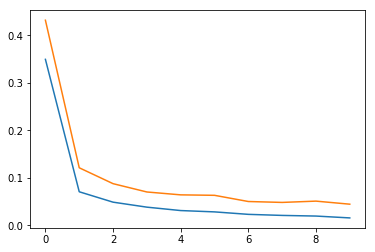

In [6]:
plt.plot(tr_loss_history)
plt.plot(val_loss_history)

In [7]:
test_result = []
for ts_row in range(mnist.test.num_examples):
    tmp = m1.predict(mnist.test.images[ts_row].reshape(1,784), use_batch = False)
    test_result.append(tmp)

In [8]:
iscorrect = np.equal(np.argmax(np.asarray(test_result).reshape(10000,10), axis = 1), np.argmax(mnist.test.labels, axis = 1))
np.mean(iscorrect)

0.9758

### Class Activation Map

In [9]:
def minmax_scaler(arr):
    _arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return _arr

In [10]:
def cam(inputimg, label, outprob, camval, cweights):
    label_cate = {int(i) : str(i) for i in range(10)}
    fig = plt.figure(figsize = (15,6))
    fig.subplots_adjust(right=0.8)
    #plt.imshow(inputimg)
    #plt.title('True : {}'.format(label_cate.get(np.argmax(label))))
    for i in range(10):
        predweights = cweights[:, i:i + 1]
        camsum = np.zeros((14, 14))

        for j in range(128):
            camsum = camsum + predweights[j] * camval[0, :, :, j]
        camavg = camsum / 128

        fig.add_subplot(2, 5, i + 1)
        tmp = imresize(camavg, [28, 28], interp='bilinear')
        plt.imshow(minmax_scaler(tmp), cmap='jet', interpolation='bilinear')
        plt.title('prediction : {},\n prob : {:.3f}'.format(label_cate.get(i), outprob[0, i]))

In [11]:
num = np.random.randint(0, mnist.test.labels.shape[0])
tmp = m1.Outforcam(mnist.test.images[num].reshape(1,784), use_batch = False)
label = mnist.train.labels[num]
inputimg = tmp.get('Ximg')
outprob = sess.run(tf.nn.softmax(tmp.get('score')))
camval = tmp.get('relu4')
cweights = tmp.get('dense_w')

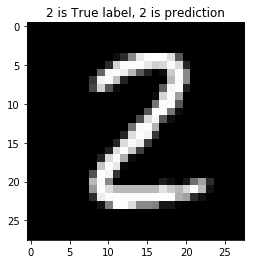

In [12]:
plt.imshow(mnist.test.images[num].reshape(28,28), cmap = 'gray')
plt.title('{} is True label, {} is prediction'.format(np.argmax(mnist.test.labels[num]),np.argmax(outprob)))

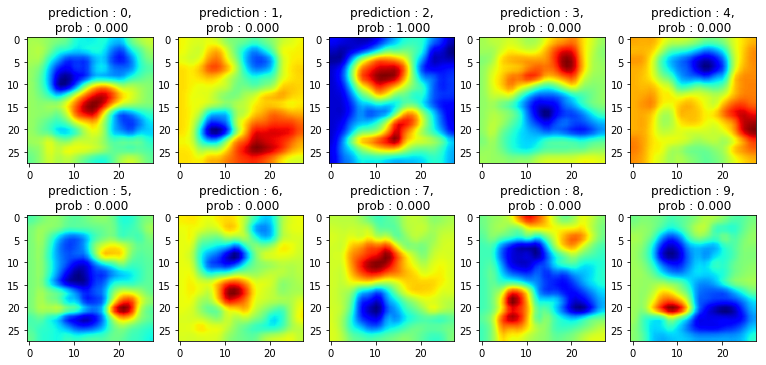

In [13]:
cam(inputimg, label, outprob, camval, cweights)